# Grad CAM

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

Grad-Cam 을 적용할 이미지를 불러옵니다 

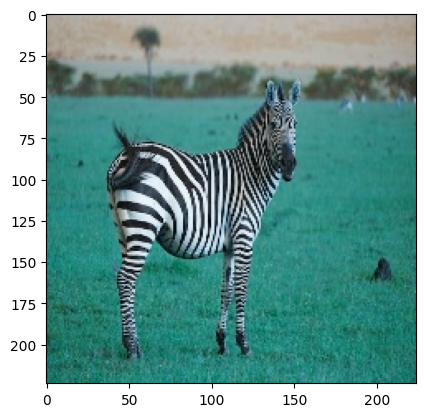

In [ ]:
filename = 'zebra.jpg'
from google.colab import drive
drive.mount('/content/drive')

img = cv2.imread("drive/MyDrive/Test/LIG/" + filename)
img = cv2.resize(img, (224, 224))

plt.imshow(img)

이미지를 전처리합니다

In [ ]:
# image resize
seed_input = cv2.resize(img, (224, 224))

# Normalization
seed_input = tf.Variable(img, dtype=tf.float32) / 255.

# set batch size dim
seed_input = tf.expand_dims(seed_input, axis=0)

적용할 모델을 불러옵니다

In [ ]:
model = tf.keras.applications.vgg16.VGG16(weights='imagenet')

model.layers[-1].activation = tf.keras.activations.linear
conv_layer = model.get_layer('block5_conv3')

model = tf.keras.Model(
    inputs=model.inputs,
    outputs=model.outputs + [conv_layer.output]
)

마지막 레이어의 피쳐맵과 아웃풋으로 나온 라벨을 저장합니다

In [ ]:
outputs, last_layer = model(seed_input)
category = tf.get_static_value(tf.argmax(outputs, -1))[0]

로스를 계산합니다

In [ ]:
with tf.GradientTape() as tape:
    tape.watch(seed_input)
    logits, penultimate_output = model(seed_input)
    loss = logits[0, category]

그레디언트를 계산합니다

In [ ]:
# dGc(y)/dy
grads = tape.gradient(loss, penultimate_output)

그레디언트의 평균값과 마지막 레이어를 곱해주고 ReLU를 적용합니다

$L_{Grad-CAM}^c=ReLU(\sum{\alpha_k^c A^k}_k)$ 

In [ ]:
weights = tf.reduce_mean(grads, axis=[0, 1, 2])
cam = tf.reduce_sum(penultimate_output * weights, axis=-1)
cam = tf.nn.relu(cam)

배치사이즈 1의 차원을 줄여줍니다 (1, 14, 14) -> (14, 14)

In [ ]:
cam = tf.squeeze(cam)
cam.shape

TensorShape([14, 14])

(14, 14) 차원의 Grad-CAM을 그려봅니다

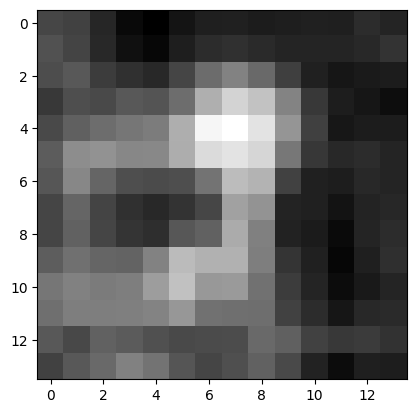

In [ ]:
plt.imshow(tf.expand_dims(cam, axis=-1), cmap='gray')

이미지 보간 방법을 이용하여 실제 크기로 키워줍니다

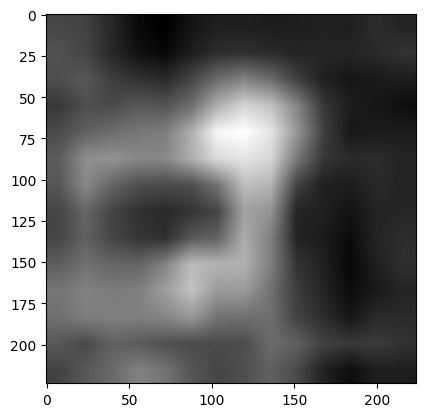

In [ ]:
cam = tf.image.resize(tf.expand_dims(cam, axis=-1), [224, 224])
plt.imshow(cam, cmap='gray')

인풋 이미지에 오버레이해서 그려봅니다

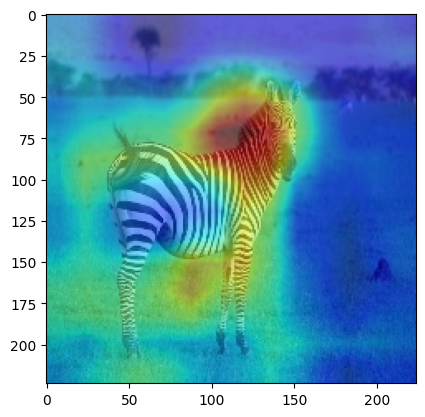

In [ ]:
cam = tf.clip_by_value(cam, 0., 1.)
cam = cam.numpy()

heatmap = np.uint((cam - cam.min()) / (cam.max() - cam.min()) * 255)
plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)

# Quiz

다음 파일들에 대해 Grad-CAM을 그려봅시다.
* cheetha.jpg
* elephant.jpg
* fox.jpg